In [1]:
from __future__ import division

In [2]:
import numpy as np

In [3]:
import healpy as hp
from healpy import query_disc, query_polygon

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/usr/local/manual/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [5]:
import opsimsummary as oss

In [6]:
import pandas as pd

In [7]:
from sqlalchemy import create_engine

In [8]:
import time

dbname = '/Users/rbiswas/data/LSST/OpSimData/minion_1016_sqlite.db'
engine = create_engine('sqlite:///' + dbname)
DD = 54
WFD = 56
OpSim_combined = pd.read_sql_query('SELECT * FROM SUMMARY WHERE PROPID in ({0}, {1})'.format(DD, WFD) , engine, 
                                   index_col='obsHistID')
OpSim_combined.reset_index(inplace=True)
OpSim_combined = OpSim_combined.drop_duplicates('obsHistID')
assert len(OpSim_combined) == OpSim_combined.obsHistID.unique().size
OpSim_combined.set_index('obsHistID', inplace=True)')
OpSim_combined.to_hdf('/Users/rbiswas/data/LSST/OpSimData/minion_1016.hdf', 'Table')

In [9]:
OpSim_combined = pd.read_hdf('/Users/rbiswas/data/LSST/OpSimData/minion_1016.hdf', 'Table')

In [10]:
assert OpSim_combined.propID.unique().all() == np.array([54, 56]).all()

In [11]:
OpSim_combined.reset_index()

,obsHistID,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,...,moonBright,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec
0,1,1016,54,316,1.676483,-1.082473,y,2922,59580.033829,0,...,0.000000,105.610378,0.920473,0,0,1.620307,0.000000,21.021236,1.643930,-1.108924
1,2,1016,54,372,1.694120,-1.033972,y,2961,59580.034275,0,...,0.000000,105.167017,0.920473,0,0,0.049266,4.574944,21.026646,1.664257,-1.060423
2,3,1016,54,441,1.708513,-0.985271,y,2999,59580.034722,0,...,0.000000,104.849578,0.920473,0,0,0.049298,4.595615,21.030520,1.680878,-1.011722
3,4,1016,54,505,1.720374,-0.936476,y,3038,59580.035169,0,...,0.000000,104.669398,0.920473,0,0,0.049266,4.605366,21.032718,1.694604,-0.962927
4,5,1016,54,587,1.730248,-0.887672,y,3077,59580.035616,0,...,0.000000,104.627207,0.920473,0,0,0.049177,4.604023,21.033233,1.706054,-0.914123
5,6,1016,54,680,1.738574,-0.838921,y,3115,59580.036062,0,...,0.000000,104.725606,0.920473,0,0,0.049050,4.592226,21.032033,1.715721,-0.865372
6,7,1016,54,770,1.745690,-0.790249,y,3154,59580.036509,0,...,0.000000,104.967791,0.920473,0,0,0.048916,4.571504,21.029077,1.723987,-0.816700
7,8,1016,54,857,1.751878,-0.741640,y,3192,59580.036955,0,...,0.000000,105.357944,0.920473,0,0,0.048813,4.543796,21.024316,1.731166,-0.768091
8,9,1016,54,957,1.757386,-0.693017,y,3231,59580.037401,0,...,0.000000,105.906574,0.920473,0,0,0.048800,4.511985,21.017621,1.737535,-0.719468
9,10,1016,54,1021,1.700932,-0.658150,y,3270,59580.037847,0,...,0.000000,102.700018,0.920473,0,0,0.056177,4.607643,21.056753,1.681628,-0.684601


In [12]:
def addCartesian(df, raCol='ditheredRA', decCol='ditheredDec'):
    #theta = - df[decCol] + np.pi/2.
    Z = np.sin(df[decCol])    
    X = np.cos(df[decCol]) * np.sin(df[raCol])
    Y = np.cos(df[decCol]) * np.cos(df[raCol])
    df['X'] = X
    df['Y'] = Y
    df['Z'] = Z

In [13]:
def addVec(df, raCol='ditheredRA', decCol='ditheredDec'):
    thetas  = - df[decCol] + np.pi /2.
    phis = df[raCol]
    df['vec'] = list(hp.ang2vec(thetas, phis))

In [14]:
addVec(OpSim_combined, raCol='ditheredRA', decCol='ditheredDec')

In [15]:
NSIDE = 256

In [16]:
tstart = time.time()
OpSim_combined['hids'] = [query_disc(NSIDE, vec, np.radians(1.75), inclusive=True) for vec in OpSim_combined.vec]
tend = time.time()
print(tend - tstart)

93.8495709896


In [17]:
from scipy import sparse

In [18]:
lens = map(len, OpSim_combined.hids.values)

In [19]:
from itertools import repeat

In [20]:
tstart = time.time()
rowdata = []
#xx = [[ind] * lens[i] for ind, i in enumerate(lens)]
_ = list(rowdata.extend(repeat(i, lens[i])) for i in xrange(len(OpSim_combined)))
tend  = time.time()
print(tend - tstart)

5.8809709549


In [21]:
tstart = time.time()
coldata = np.concatenate(OpSim_combined.hids.values)
tend  = time.time()
print(tend - tstart)

7.4017291069


In [22]:
_aa = np.shape(coldata) 
_bb = np.shape(rowdata)
assert _aa == _bb

In [23]:
shape=(len(OpSim_combined), hp.nside2npix(256))

In [24]:
print(shape)

(2194905, 786432)


In [25]:
tstart = time.time()
spmat = sparse.csr_matrix((np.ones(len(rowdata)), (np.asarray(rowdata), coldata)), shape=shape)
tend = time.time()
print(tend - tstart)

84.9765369892


In [ ]:
print(tend - tstart)

In [ ]:
x = spmat.transpose()

In [26]:
tstart = time.time()
obs = spmat.sum(axis=0)
tend = time.time()
print(tend - tstart)

4.01137304306


In [ ]:
shape

In [ ]:
len(obs.transpose())

In [27]:
obs = np.asarray(obs).reshape(len(obs.transpose())) #, np.shape(obs)[1])

In [28]:
obs = np.where(obs == 0., hp.UNSEEN, obs)

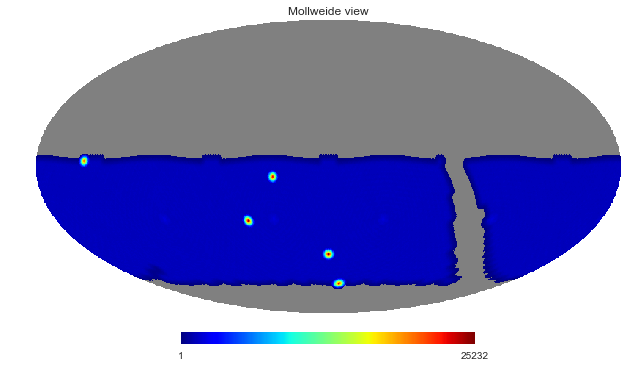

In [29]:
hp.mollview(obs)

In [ ]:
shape

In [ ]:
x.shape[0]

In [ ]:
obs = x.sum(axis=1).reshape(x.shape[0])

In [ ]:
hp.mollview(obs)

In [ ]:
hp.mollview(map=)

In [ ]:
plt.hist(x)

In [ ]:
from itertools import repeat

In [ ]:
newdata = [elem for subl in xx for elem in subl]

In [ ]:
newdata == datarows

In [ ]:
len(OpSim_combined)

In [ ]:
xx = datarows

In [ ]:
len(newdata)

In [ ]:
len(datarows)

In [ ]:
tend - tstart

In [ ]:
OpSim_combined.reset_index(inplace=True)

In [ ]:
shape[0] * shape[1]

In [ ]:
OpSim_combined.index.max()# - len(OpSim_combined)

In [ ]:
OpSim_combined[OpSim_combined.expMJD.diff() < 0]

In [ ]:
OpSim_combined['hids']

In [ ]:
OpSim_combined['hidsFull'] = [query_disc(64, vec, np.radians(1.75), inclusive=False) for vec in OpSim_combined.vec]

In [ ]:
OpSim_combined.expMJD.min()

In [ ]:
len(OpSim_combined.query('expMJD  < {0} + 170 and expMJD > {0}'.format(59580. + 365. * 4.0)).query('fieldID == 309'))

In [ ]:
set(OpSim_combined.hids.values[0]) - set(OpSim_combined.hidsFull.values[0])

In [ ]:
inside = len(set(OpSim_combined.hids.values[0]).intersection(set(OpSim_combined.hidsFull.values[0])))

In [ ]:
OpSim_combined.hidsFull.values[0]

In [ ]:
hidvals = set()
for row in OpSim_combined.hids.values:
    hidvals.update(set(row))

In [ ]:
len(hidvals) / hp.nside2npix(256)

In [ ]:
hidvals = np.asarray(list(hidvals))

In [ ]:
len(hidvals) / 20. * 9.0 /60. / 60.

In [ ]:
fields = [OpSim_combined[OpSim_combined['hids'].apply(lambda x: hid in x)].fieldID for hid in hidvals[:100]]

In [ ]:
Twinkleshidvals = set()
for row in OpSim_combined.query('fieldID == 1427').hids.values:
    Twinkleshidvals.update(set(row))

In [ ]:
Twinkleshidvals  = np.asarray(list(Twinkleshidvals))

In [ ]:
len(Twinkleshidvals)

In [ ]:
len(Twinkleshidvals)

In [ ]:
%timeit _ = OpSim_combined[OpSim_combined.hids.apply(lambda x: 36006 in x)]

In [ ]:
np.pi * np.radians(1.75)**2./hp.nside2pixarea(64)

In [ ]:
Twinklesfields = [OpSim_combined[OpSim_combined.hids.apply(lambda x: hid in x)]for hid in Twinkleshidvals]

In [ ]:
mapVal = np.ones(hp.nside2npix(64)) * hp.UNSEEN

In [ ]:
mapVal[Twinkleshidvals] = 1.

In [ ]:
fig ax

In [ ]:
phi, theta = np.degrees(OpSim_combined.query('fieldID == 1427')[['fieldRA', 'fieldDec']].values[0])

In [ ]:
theta=-theta + 90.

In [ ]:
hp.dir2vec()

In [ ]:
import matplotlib

In [ ]:
hp.mollzoom(mapVal, rot=(phi, theta, 0))

In [ ]:
hp.mollview(mapVal)

In [ ]:
OpSim_combined.query('fieldID == 1427').fieldID.size

In [ ]:
plt.hist(map(len, Twinklesfields), histtype='step', lw=2., alpha=1.)
plt.axvline(24175)

In [ ]:
OpSim_combined.query('fieldID == 1427')['hids'].apply(lambda x: hid in x).fieldID# for hid in Twinkleshidvals]

In [ ]:
Twinklesfields = [OpSim_combined.query('fieldID == 1427')[OpSim_combined.query('fieldID == 1427')['hids'].apply(lambda x: hid in x)].fieldID for hid in Twinkleshidvals

In [ ]:
Twinklesfields

In [ ]:
plt.stem(map(len, fields))

In [ ]:
fields[0]

In [ ]:
fields[20]

In [ ]:
np.array(map(lambda x: len(x.unique()), fields)) > 1

In [ ]:
plt.plot(map(lambda x: len(x.unique()), fields), map(len, fields), 'o')

In [ ]:
map(lenfields[40:50]

In [ ]:
plt.plot(map(lambda x: len(x.unique()), fields), map(len, fields), 'o')

In [ ]:
hp.pix2ang(64, hidvals[:100])

In [ ]:
OpSim_combined.['vec'].apply(hp.query_disc(), args=(np.radians(1.75), ))a


In [ ]:
x[0]

In [ ]:
np.shape(x)

In [ ]:
xx = [query_disc(256, vec, np.radians(1.75), inclusive=True) for vec in OpSim_combined.vec]

In [ ]:
OpSim_combined['hids'] = [query_disc(256, vec, np.radians(1.75), inclusive=True) for vec in OpSim_combined.vec]

In [ ]:
len(OpSim_combined)

In [ ]:
hidvals = np.unique(np.asarray([OpSim_combined.hids.values]))

In [ ]:
mylist = []
for hids in xx:
    for elem in hids
       mylist.append(elem)

In [ ]:
%%timeit  
hidvals = np.unique(np.array([elem for hids in xx for elem in hids]))

In [ ]:
np.vstack(np.array([np.array([1., 2.]), np.array([2., 3.])]))

In [ ]:
xx = OpSim_combined.hids.values[0:10].copy()

In [ ]:
hidvals = np.unique(np.asarray([xx for xx in OpSim_combined.hids.values]))

In [ ]:
%%timeit
hidvals = OpSim_combined.hids.values)

In [ ]:
OpSim_combined[OpSim_combined.hids.apply(lambda x: 743074 in x)].fieldID.unique()

In [ ]:
OpSim_combined.ix[1, 'hids']

In [ ]:
%%timeit 
hids = query_disc(256, OpSim_combined['vec'], np.radians(1.75), inclusive=True)


In [ ]:
import healpy as hp

In [ ]:
np.pi * np.radians(1.75)**2.

In [ ]:
np.radians(np.sqrt(9.6))**2.

In [ ]:
hp.nside2pixarea(256)

In [ ]:
hp.ang2vec(np.pi/2., np.pi)

In [ ]:
hids

In [ ]:
OpSim_combined['hids'] = [query_disc(64, (OpSim_combined.ix[ind, 'X'],OpSim_combined.ix[ind, 'Y'], OpSim_combined.ix[ind, 'Z']), np.radians(1.75), 
                  inclusive=True) for ind in OpSim_combined.index]

In [ ]:
OpSim_combined.ix[1, 'hids']

In [ ]:
OpSim_combined['hids'] = [np.random.randint(1, 500, 16) for x in range(len(OpSim_combined))]

In [ ]:
def contains(x, y):
    return x in y

In [ ]:
def overlaps(hid, df):
    x = df.hids.apply(hid in)
    return df[x]

In [ ]:
from __future__ import division

In [ ]:
%timeit len(OpSim_combined[OpSim_combined.hids.apply(lambda x: 348 in x)])

In [ ]:
fraction = []
ss = len(OpSim_combined)
for i in range(1, 501):
    fraction.append(len(OpSim_combined[OpSim_combined.hids.apply(lambda x: i in x)]))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
np.asarray(fraction) /ss  - 16./ 500.

In [ ]:
plt.hist(np.array(fraction)/ss)

In [ ]:
len(OpSim_combined)

In [ ]:
overlaps(348, OpSim_combined)

In [ ]:
contains(348, OpSim_combined.hids)

In [ ]:
OpSim_combined.query('316 == fieldID')

In [ ]:
for lst in OpSim_combined['hids']:
    

In [ ]:
def get_overlappObs(OpSim_combined, hid):
    OpSim_combined['overlap'] = hid in 